In [19]:
import numpy as np
import scipy as sp
import pandas as pd
import pymc as pm
import arviz as az
from matplotlib import pyplot as plt
import seaborn as sns
from math import factorial as f

# Binomial distribution
def dbinom(x,n,p):
    return f(n)/(f(x)*f(n-x))*p**(x)*(1-p)**(n-x)

### Our first model. Estimating the presence/absence of frogs at a pond.

**Scenario**: We go to a pond 30 times and record the presence (1) or absence (0) of frogs, and try and estimate the probability of seeing a frog when visiting the pond.

**Workflow**

1.  Define what we are estimating   
2.  Build generative model to create simulated data
3.  Build statistical model
4.  Test statistical model with simulated data
5.  Apply to real data.

### Generative model and simulated data.

In [12]:
# number of trips to pond
n_trips = 30

# the true probability of seeing a frog in this pond
true_prob = 0.3

# simulate data with our generative model
sim_data = np.random.binomial(n=1, size=n_trips, p=true_prob)

# number of times seen a frog
n_frogs = sum(sim_data)

sim_data

array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0])

### Build statistical model: grid approximation
**Model Components**
1. **Grid**, a finite set of parameters values to be used
2. **Prior Distribution**, prior probability of the parameter at each probability
3. **Data Likelihood**, the distribution function assigned to our observed variables. This function gives us the likelihood of the data for every plausible value of our parameter.
4. **Posterior Distribution**, contains the probability of different parameter values, conditional on the data and model.

#### Bayesian Notation

$$F \sim Binomial(n, p)$$
$$p \sim Uniform(0,1)$$

In [22]:
# grid approximation
par_grid = np.linspace(start=0, stop=1, num=20) # 20 candidate values of p

# uniform prior
prior = np.repeat(1, 20)
prior = prior/sum(prior)

# likelihood
likelihood = dbinom(n_frogs, n_trips, par_grid)

# posterior
posterior = likelihood*prior/sum(likelihood*prior)

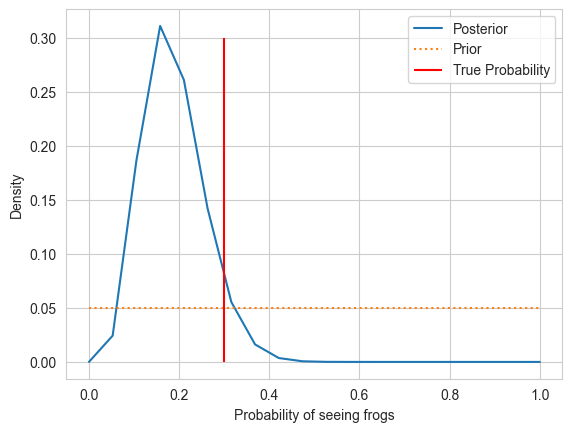

In [30]:
plt.plot(par_grid, posterior)
plt.plot(par_grid, prior,linestyle=":")
plt.vlines(0.3, ymin=0, ymax=0.3, colors="red")
plt.xlabel('Probability of seeing frogs')
plt.ylabel('Density')
plt.legend(['Posterior', 'Prior', 'True Probability']);

In [41]:
# summarise our posterior - grid approximation
samples = np.random.choice(par_grid, p=posterior, size=1000, replace=True)
# mean
samples.mean()

0.18905263157894733

In [38]:
# how much of the posterior is above/below a value?
posterior[ par_grid < 0.4 ].sum(), posterior[ par_grid > 0.4 ].sum()

(0.9957431054321122, 0.00425689456788766)

In [40]:
# compatibility intervals
# highest posterior density interval (HPDI) - best representatives of parameter values
az.hdi(samples, hdi_prob=0.5)

array([0.15789474, 0.21052632])

### Build statistical model: MCMC
- **Model data,** a list containing our variables and data
- **Prior Distribution**, prior probability of the parameter at each probability
- **Data Likelihood**, the distribution function assigned to our observed variables. This function gives us the likelihood of the data for every plausible value of our parameter.

In [39]:
with pm.Model() as frog_model:
    p = pm.Uniform('p', 0, 1) # uniform prior
    frogs = pm.Binomial('frogs', n=n_trips, p=p, observed=n_frogs )
    
    idata = pm.sample() # sample from posterior

az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.189,0.067,0.075,0.322,0.002,0.001,1486.0,2345.0,1.0


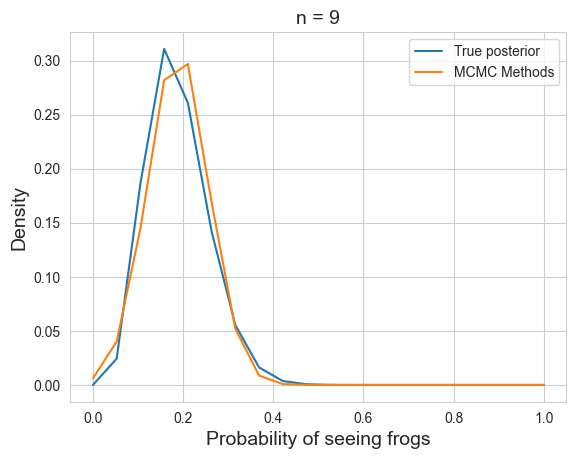

In [44]:
# analytical calculation
y1 = dbinom(n_frogs,n_trips,par_grid)
plt.plot(par_grid, y1/sum(y1), label='True posterior')

y2 = sp.stats.norm.pdf(par_grid, idata['posterior']['p'].mean(), idata['posterior']['p'].std())
plt.plot(par_grid, y2/sum(y2), label='MCMC Methods')
plt.legend()

plt.title('n = 9', fontsize=14)
plt.xlabel('Probability of seeing frogs', fontsize=14)
plt.ylabel('Density', fontsize=14);